# Neural Networks

In [1]:
# importing basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Specific neural network models & layer types
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding, LSTM, GRU, BatchNormalization, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.utils import timeseries_dataset_from_array

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Ignore futurewarnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading in the data
columns = pd.read_csv('data/features2.txt', header = None)

X_train_orig = pd.read_csv('data/Train/X_train.txt', names = columns[0], sep=' ')
X_test_orig = pd.read_csv('data/Test/X_test.txt', names = columns[0], sep=' ')

y_train_orig = pd.read_csv('data/Train/y_train.txt', sep=' ', header = None)
y_test_orig = pd.read_csv('data/Test/y_test.txt', sep=' ', header = None)

In [3]:
X_train = X_train_orig.values
X_test = X_test_orig.values

In [4]:
# One hot encoding target data
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train_orig).toarray()
y_test = ohe.fit_transform(y_test_orig).toarray()

In [5]:
# split train and validation set for OHE data
X_train2, X_validation, y_train2, y_validation = train_test_split(X_train, y_train, test_size=0.1)

In [6]:
# split train and validation set for orig data
# X_train2, X_validation, y_train2, y_validation = train_test_split(X_train_orig, y_train_orig, test_size=0.1)

In [7]:
#train_df = pd.concat((X_train2, y_train2), axis=1) 
#val_df = pd.concat((X_validation, y_validation), axis=1)
#test_df = pd.concat((X_test, y_test), axis=1)

**PLAN**

For neural networks, you can simply try a fully connected NN with a few layers, 

first ignoring the time component and previous activity

then second, you can do RNNs by feeding in say 10 time-steps and predicting the next activity

### Building a Neural Network Using Keras

The process of building a network using Keras can generally be broken down into four separate steps:
1. **Build the model**: This is the step where we will declare the structure of the network — primarily the types and sizes of the hidden layers.
2. **Compile the model**: This step allows us to customize some of the settings that will be used for training.
3. **Train the model**
4. **Evaluate the model and generate predictions**

### Fully Connected Neural Network

USE SOFTMAX FOR OUTPUT LAYER BECAUSE IT ENSURES ALL PROBABILITIES ADD UP TO 1

ADAM OPTIMIZER BECAUSE IT IS BEST ADAPTIVE OPTIMIZER, GOOD WITH DATASETS WITH LARGE # OF FEATURES
https://outline.com/X7kdTG

LOSS FUNCTION WILL BE SparseCategoricalCrossentropy() FOR CROSS ENTROPY BETWEEN LABELS AND PREDICTIONS

METRICS WILL BE USING SparseCategoricalAccuracy() FOR MULTIVARIATE CLASSIFICATION


#### 3 Layer NN

In [8]:
# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
# We'll be using the RELU activation function for our layers for the unbound benefit
# Dense layers will be used to create a fully connected neural network model

model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(40, activation="relu"))


# Declare the output layer
# Our output layer has 12 units for the 12 different activities to be classified
# There are 6 main actions, and 6 transition actions
# Transition actions are when the participant transitions to the next position
model.add(layers.Dense(13, activation="softmax"))

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

2021-09-24 15:57:13.374521: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Fit the model
history = model.fit(X_train_orig, y_train_orig, epochs=100, verbose=0)

2021-09-24 15:57:13.481502: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [10]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model.evaluate(X_test_orig, y_test_orig, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

predictions = model.predict(X_test_orig)

Train Accuracy: 0.9933
Test Accuracy: 0.9317


#### 5 Layer NN 

In [11]:
# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
# We'll be using the RELU activation function for our layers for the unbound benefit
# Dense layers will be used to create a fully connected neural network model

model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(40, activation="relu"))

# Declare the output layer
# Our output layer has 12 units for the 12 different activities to be classified
# There are 6 main actions, and 6 transition actions
# Transition actions are when the participant transitions to the next position
model.add(layers.Dense(13, activation="softmax"))

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [12]:
# Fit the model
history = model.fit(X_train_orig, y_train_orig, epochs=100, verbose=1)

Epoch 1/100
243/243 [==============================] - 1s 1ms/step - loss: 0.8701 - sparse_categorical_accuracy: 0.6611
Epoch 2/100
243/243 [==============================] - 0s 1ms/step - loss: 0.3391 - sparse_categorical_accuracy: 0.8682
Epoch 3/100
243/243 [==============================] - 0s 1ms/step - loss: 0.2026 - sparse_categorical_accuracy: 0.9182
Epoch 4/100
243/243 [==============================] - 0s 1ms/step - loss: 0.1724 - sparse_categorical_accuracy: 0.9298
Epoch 5/100
243/243 [==============================] - 0s 1ms/step - loss: 0.1348 - sparse_categorical_accuracy: 0.9423
Epoch 6/100
243/243 [==============================] - 0s 1ms/step - loss: 0.1284 - sparse_categorical_accuracy: 0.9452
Epoch 7/100
243/243 [==============================] - 0s 1ms/step - loss: 0.1159 - sparse_categorical_accuracy: 0.9534
Epoch 8/100
243/243 [==============================] - 0s 1ms/step - loss: 0.1098 - sparse_categorical_accuracy: 0.9543
Epoch 9/100
243/243 [===================

In [13]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model.evaluate(X_test_orig, y_test_orig, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

predictions = model.predict(X_test_orig)

Train Accuracy: 0.9921
Test Accuracy: 0.9355


### Recurrent Neural Network

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [28]:
sample_length = 20
stride = 5

X_train3 = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train2, None, sequence_length=sample_length, sequence_stride=stride, shuffle=False, batch_size = 540)
y_train3 = tf.keras.preprocessing.timeseries_dataset_from_array(
  y_train2, None, sequence_length=sample_length, sequence_stride=stride, shuffle=False, batch_size = 540)
X_val = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_validation, None, sequence_length=sample_length, sequence_stride=stride, shuffle=False, batch_size = 60)
y_val = tf.keras.preprocessing.timeseries_dataset_from_array(
  y_validation, None, sequence_length=sample_length, sequence_stride=stride, shuffle=False, batch_size = 60)

for batch in zip(X_train3, y_train3):
    inputs, targets = batch
    #assert np.array_equal(inputs[0], X_train2[:sample_length])

    # second sample equals output timestamps 20-40
    #assert np.array_equal(targets[1], y_train2[sample_length:2*sample_length])
    break
for batch in zip(X_val, y_val):
    input_val, target_val = batch
    #assert np.array_equal(input_val[0], X_validation[:sample_length])

    # second sample equals output timestamps 20-40
    #assert np.array_equal(target_val[1], y_validation[sample_length:2*sample_length])
    break

In [29]:
print(f"The shape of the X_train data is: {X_train2.shape}")
print(f"The shape of the y_train data is: {y_train2.shape}")
print(f"The shape of the X_validation data is: {X_validation.shape}")
print(f"The shape of the y_validation data is: {y_validation.shape}")

The shape of the X_train data is: (6990, 561)
The shape of the y_train data is: (6990, 12)
The shape of the X_validation data is: (777, 561)
The shape of the y_validation data is: (777, 12)


In [30]:
print(f"The shape of the inputs data is: {inputs.shape}")
print(f"The shape of the targets data is: {targets.shape}")
print(f"The shape of the validation input data is: {input_val.shape}")
print(f"The shape of the validation targets data is: {target_val.shape}")

The shape of the inputs data is: (540, 20, 561)
The shape of the targets data is: (540, 20, 12)
The shape of the validation input data is: (60, 20, 561)
The shape of the validation targets data is: (60, 20, 12)


In [31]:
RNN = Sequential()
RNN.add(GRU(128, activation='relu', return_sequences=True))
#RNN.add(Embedding(562, 128))

# the intermediate recurrent layers should return full sequences
RNN.add(GRU(64, activation='relu', return_sequences=True))
RNN.add(BatchNormalization())
RNN.add(Dropout(0.15))

# the last recurrent layer only returns the final output
RNN.add(GRU(32, activation='relu', return_sequences=True))
RNN.add(BatchNormalization())
RNN.add(Dropout(0.15))

RNN.add(Dense(16, activation='relu'))
RNN.add(BatchNormalization())
RNN.add(Dropout(0.15))

RNN.add(Dense(12, activation='softmax'))

In [32]:
# Compile model
RNN.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
)

In [33]:
history = RNN.fit(inputs, targets,
        #batch_size=1024,
        epochs=20,
        validation_data=(input_val, target_val),
        verbose = 0)

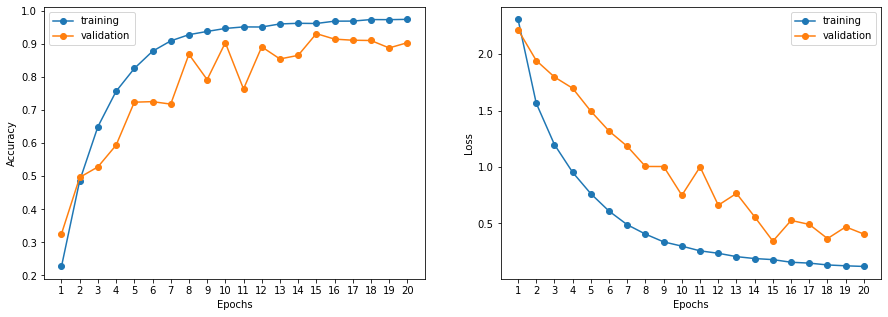

In [36]:
epochs = range(1, 21)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

In [37]:
# Display its summary
RNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 20, 128)           265344    
_________________________________________________________________
gru_4 (GRU)                  (None, 20, 64)            37248     
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 64)            256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 20, 32)            9408      
_________________________________________________________________
batch_normalization_4 (Batch (None, 20, 32)            128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 32)           

classification score
confusion matricies

20 time steps of observations go in, make prediction for 20 activities all at once
**one shot prediction

---

#### RNN Model Evaluation